# Training a CNN for DPU compilation

In this notebook we show how to train a simple Convolutional Neural Network (CNN)
on the MNIST handwritten digit dataset for deployment on the DPU. We will cover:

* Loading and pre-processing the imagenet dataset
* Training a CNN with Keras and Tensorflow
* Freezing the trained model
* Quantizing and evaluating the quantized model
* Compiling for DPU using the Vitis AI compiler

**Note**:
* This notebook should be run on a proper X86 machine; it has to support
AVX2 and FMA instructions sets. To check:
```shell
grep avx2 /proc/cpuinfo
grep fma /proc/cpuinfo
```
* Please make sure the following has been done in terminal before you start this notebook:
```shell
conda activate vitis-ai-tensorflow
yes | pip install matplotlib keras==2.2.5
```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from shutil import copyfile
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import keras
from keras.layers import Dense, Conv2D, InputLayer, Flatten, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


## Load dataset

The MNIST dataset comes with 60k training and 10k test examples that are
28x28 grayscale images, along with their labels which are just the 
corresponding digits saved as integers. We can use the `keras.datasets`
utility to load the MNIST dataset straight into our Jupyter environment.

Next we will normalize the training and test images. We also need to add
color channel. All these pre-processing steps are required by Conv2D layers.

In [2]:
print("The number of images with facemask labelled 'yes':",len(os.listdir('facemask-dataset/yes')))
print("The number of images with facemask labelled 'no':",len(os.listdir('facemask-dataset/no')))

The number of images with facemask labelled 'yes': 1916
The number of images with facemask labelled 'no': 1930


In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
import cv2
import os

data = []
labels = []

mylist = os.listdir("facemask-dataset")

for x in mylist:
    mylist2 = os.listdir("facemask-dataset/"+str(x))
    label = str(x)
    for y in mylist2:
        # extract the class label from the filename

        # load the input image (224x224) and preprocess it
        image = load_img("facemask-dataset/"+str(x)+"/"+str(y),color_mode="grayscale", target_size=(64, 64))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(x_train, x_test,y_train, y_test) = train_test_split(data, labels,
                                                        test_size=0.20, stratify=labels, random_state=42)

print('Training data: {}, {}'.format(x_train.shape, y_train.shape))
print('Test data: {}, {}'.format(x_test.shape, y_test.shape))


/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib/python3.6/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training data: (3076, 64, 64, 1), (3076, 2)
Test data: (770, 64, 64, 1), (770, 2)


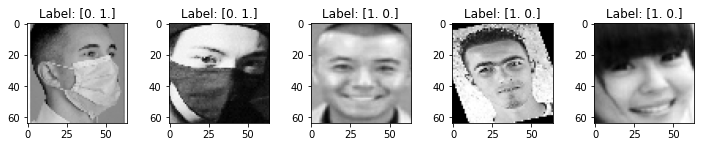

In [4]:
fig, axs = plt.subplots(1, 5, figsize=(10, 10))
plt.tight_layout()

for i in range(5):
    axs[i].imshow(x_train[i].reshape(64, 64), 'gray')
    axs[i].set_title('Label: {}'.format(y_train[i]))

## Train the model

Create a sequential model by passing a list of layers. Because the MNIST
dataset is not difficult, we can use a very simple network with a single 
convolutional layer.

In [5]:
model = keras.models.Sequential([
    InputLayer(input_shape=(64, 64, 1), name='input_data'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax', name='output_logits')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
output_logits (Dense)        (None, 2)                

Configure the model for training: choose desired optimizer, loss function
and metrics to observe over the training period.

In [7]:
model.compile(optimizer='adam',
              loss="binary_crossentropy", 
              metrics=['accuracy'])

Now we can train the model.

In [8]:
history = model.fit(x_train,y_train,epochs=10)

Epoch 1/10
3076/3076 [==============================] - 28s 9ms/step - loss: 0.4268 - acc: 0.7923
Epoch 2/10
3076/3076 [==============================] - 29s 10ms/step - loss: 0.2392 - acc: 0.9002
Epoch 3/10
3076/3076 [==============================] - 29s 10ms/step - loss: 0.1478 - acc: 0.9402
Epoch 4/10
3076/3076 [==============================] - 29s 10ms/step - loss: 0.1086 - acc: 0.9584
Epoch 5/10
3076/3076 [==============================] - 26s 8ms/step - loss: 0.0716 - acc: 0.9730
Epoch 6/10
3076/3076 [==============================] - 25s 8ms/step - loss: 0.0487 - acc: 0.9828
Epoch 7/10
3076/3076 [==============================] - 28s 9ms/step - loss: 0.0276 - acc: 0.9912
Epoch 8/10
3076/3076 [==============================] - 29s 9ms/step - loss: 0.0101 - acc: 0.9984
Epoch 9/10
3076/3076 [==============================] - 25s 8ms/step - loss: 0.0035 - acc: 0.9997
Epoch 10/10
3076/3076 [==============================] - 25s 8ms/step - loss: 0.0014 - acc: 1.0000


We can inspect the training results by plotting the collected data in the
`history` object.

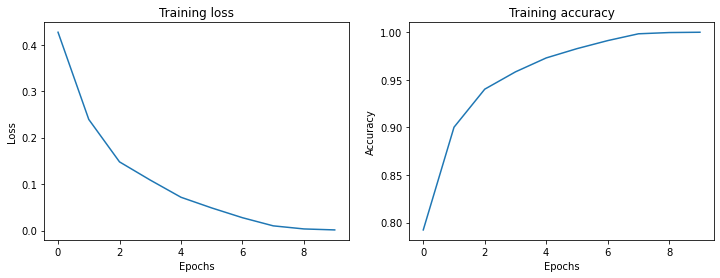

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['loss'])
axs[0].set_title('Training loss')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(history.history['acc'])
axs[1].set_title('Training accuracy')
axs[1].set(xlabel='Epochs', ylabel='Accuracy')
plt.show()

In [10]:
loss, accuracy = model.evaluate(x_test,y_test)
print("Test loss: {}".format(loss))
print("Test accuracy: {}".format(accuracy))

770/770 [==============================] - 2s 2ms/step
Test loss: 0.15014162841071557
Test accuracy: 0.9597402597402598


Evaluate the trained model on the test dataset.

## Save checkpoint
We use the [checkpoint saving method for the Vitis AI flow](https://github.com/Xilinx/Vitis-AI-Tutorials/tree/Keras-Freeze-with-Vitis-AI). We can get the session and graph from the `keras.backend` module
and use those to save a Tensorflow checkpoint compatible with the Vitis AI
workflow. The following cell does the following:

1. Set up Tensorflow saver object
2. Fetch the Tensorflow session using the Keras backend
3. Get the Tensorflow session graph
4. Write out Tensorflow checkpoint and inference graph for use with the freeze_graph script

In [11]:
saver = tf.train.Saver()
tf_session = keras.backend.get_session()
input_graph_def = tf_session.graph.as_graph_def()
save_path = saver.save(tf_session, './checkpoint.ckpt')
tf.train.write_graph(input_graph_def,
                     './', 'face_binary.pb', as_text=False)

'./face_binary.pb'

As well as saving the checkpoint we also need to make a note of the input 
and output nodes of the graph for freezing and quantization. We made our
lives a bit easier by naming the input and output layers, which results
in our input and output nodes being named `input_data` and 
`output_logits/Softmax` respectively. You can check the node names in the 
list defined below.

In [12]:
nodes_names = [node.name for node in 
               tf.get_default_graph().as_graph_def().node]

## Freeze Tensorflow graph
The Vitis AI flow requires a frozen model for quantization. We can obtain a binary
protobuf file of our frozen model by using the Tensorflow `freeze_graph` utility.

In [13]:
!freeze_graph \
    --input_graph face_binary.pb \
    --input_checkpoint checkpoint.ckpt \
    --input_binary true \
    --output_graph frozen.pb \
    --output_node_names output_logits/Softmax

Instructions for updating:
Use standard file APIs to check for files with this prefix.
W1024 01:20:04.157625 140152281343808 deprecation.py:323] From /opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib/python3.6/site-packages/tensorflow_core/python/tools/freeze_graph.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
2020-10-24 01:20:04.270913: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-10-24 01:20:04.277714: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2304005000 Hz
2020-10-24 01:20:04.277924: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558c8ecf28e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-24 

## Quantization
We will save some of our training data as calibration data for
`vai_q_tensorflow`, then use that along with the frozen graph to quantize our model.

`vai_q_tensorflow inspect` can be used to confirm available input and output
node names.

In [14]:
!vai_q_tensorflow inspect --input_frozen_graph=frozen.pb

Op types used: 13 Const, 8 Identity, 4 BiasAdd, 3 Relu, 2 Conv2D, 2 MatMul, 2 MaxPool, 1 Pack, 1 Placeholder, 1 Prod, 1 Reshape, 1 Shape, 1 Softmax, 1 StridedSlice

Found 1 possible inputs: (name=input_data, type=float(1), shape=[?,64,64,1]) 
Found 1 possible outputs: (name=output_logits/Softmax, op=Softmax) 


In [15]:
np.savez('./calib_data.npz', data = x_train[:1000])

We will save a portion of our training data for quantization.
Recommended number is around 100-1000 for images.

In [16]:
%%writefile input_func.py
import numpy as np

data = np.load('calib_data.npz')['data']

batch_size=10

def calib_input(iter):

    calib_data = data[iter*batch_size:(iter+1)*batch_size]

    return {'input_data': calib_data}

Overwriting input_func.py


In [17]:
!vai_q_tensorflow quantize \
    --input_frozen_graph frozen.pb \
    --input_fn input_func.calib_input \
    --output_dir quantized \
    --input_nodes input_data \
    --output_nodes output_logits/Softmax \
    --input_shapes ?,64,64,1 \
    --calib_iter 100

INFO: Checking Float Graph...
INFO: Float Graph Check Done.
INFO: Calibrating for 100 iterations...
100% (100 of 100) |######################| Elapsed Time: 0:00:58 Time:  0:00:58
INFO: Calibration Done.
INFO: Generating Deploy Model...
INFO: Deploy Model Generated.
********************* Quantization Summary *********************      
INFO: Output:       
  quantize_eval_model: quantized/quantize_eval_model.pb       
  deploy_model: quantized/deploy_model.pb


## Evaluate quantized model
The quantizer produces a special model called `quantize_eval_model.pb`, 
which we can use to load up like a regular Tensorfow binary graph and 
evaluate its performance.

Because we already have a graph definition in our session, we need to
reset the default graph so as to not interfere with the graph we are 
about to load from the frozen model.

In [18]:
tf.reset_default_graph()

In order to evaluate a quantized model we have to import `tensorflow.contrib.decent_q`, 
otherwise the model evaluation will error out. We will use standard 
Tensorflow 1, to set up the graph for evaluation.

In the next cell, we will read in a frozen binary graph and add the 
accuracy metric.

In [19]:
import tensorflow.contrib.decent_q

with tf.gfile.GFile('quantized/quantize_eval_model.pb', "rb") as f:
    graph = tf.GraphDef()
    graph.ParseFromString(f.read())

tf.import_graph_def(graph,name = '')

input_data = tf.get_default_graph().get_tensor_by_name('input_data'+':0')
labels = tf.placeholder(tf.int64, shape=[None,])
logits = tf.get_default_graph().get_tensor_by_name(
    'output_logits/Softmax'+':0')

nn_output = tf.argmax(logits, 1)
correct_prediction = tf.equal(nn_output, labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.initializers.local_variables())
    acc = accuracy.eval(feed_dict={input_data: x_test, labels: y_test})

ValueError: Cannot feed value of shape (770, 2) for Tensor 'Placeholder:0', which has shape '(?,)'

Run a Tensorflow session to evaluate the test accuracy of the quantized model.
If the accuracy at this stage is acceptable, we can proceed to compilation 
and deployment on DPU.

## Compilation
Now that we are satisfied with our quantized model accuracy, we can compile it and move onto the target.

This example targets the ZCU111 (or ZCU102 which uses the same DPU 
configuration as ZCU102). You can target a different architecture by
specifying its configuration json file with the `--arch` flag.

In [21]:
!vai_c_tensorflow \
    --frozen_pb quantized/deploy_model.pb \
    --arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json \
    --output_dir . \
    --net_name face_binary_classifier

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[VAI_C][Warning] layer [output_logits_Softmax] (type: Softmax) is not supported in DPU, deploy it in CPU instead.

Kernel topology "face_binary_classifier_kernel_graph.jpg" for network "face_binary_classifier"
kernel list info for network "face_binary_classifier"
                               Kernel ID : Name
                                       0 : face_binary_classifier_0
                                       1 : face_binary_classifier_1

                             Kernel Name : face_binary_classifier_0
--------------------------------------------------------------------------------
                             Kernel Type : DPUKernel
                               Code Size : 0.01MB
                              Param Size : 1.60MB
                           Workload MACs : 131.65MOPS
                         IO Memory Space : 0.09MB
      

Note that some node names are different now, take a note of these, as they are required by the DNNDK API on the target. 

* Input node: `conv2d_1_convolution`
* Output node: `output_logits_MatMul`
* Kernel name: `mnist_classifier_0`

Copyright (C) 2020 Xilinx, Inc